# Exploring MNE's data structure
---

## Learning Objectives
- Import raw EEG data using MNE
- Examine the structure of an MNE `Raw` object
- Access and view different attributes of a `Raw` data object
- Visualize the positions of EEG electrodes 


---
## Introduction

In this lesson, we will load a raw EEG data file using MNE and gain an understanding of how MNE stores data. This is an important first step to working with data in MNE.


## Load packages

In [ ]:
import mne
mne.set_log_level('error')

import numpy as np
import matplotlib.pyplot as plt
import glob

:::{tip}
In the above cell, we ran a command after importing mne, `mne.set_log_level('error')`. If you don't run this when using MNE, you will find that MNE provides a lot output, and often including some concerning-looking Python warning messages. Most of these warnings are safely ignored. I generally find this output more confusing than helpful, and turn it off routinely. For our lessons we will keep the output off because it just creates confusion.
:::

## Import raw data

For EEG, raw data is typically stored in a one or more files containing continuous EEG data. There are many different proprietary file formats for EEG data; most of these are developed by the manufacturer of a particular EEG system, since an integral part of an EEG system is software to save the data for later analysis. Fortunately, MNE provides functions to import data from most common EEG systems. 

In the present case, we are working with data from a system sold by Brain Products, whose software is called *Brain Vision*. So we will use MNE's `read_raw_brainvision()` function. The Brain Vision format actually specifies *three files* for any given data set. The three files are all created at the time that the EEG data is acquired, and it's important to ensure that all three are copied when moving them around. The files are as follows:
- `*.eeg` is the actual EEG data (electrical potential measurements for all electrodes, at all time points). This is stored in a compressed (binary) format
- `*.vmrk` is a text file containing all of the markers (*trigger codes*) that were sent to the EEG system during data collection, by the stimulus computer. These typically encode the onset of various stimuli, and times of any responses by the participant, as well as and what each stimulus/response was. 
- `*.vhdr` is a text file with header information, or **metadata** about the data set, including technical details such as the sampling rate, and the settings of the EEG amplifier during the recording. The `.vhdr` file is particularly important because it specifies the file names of the `.eeg` and `.vmrk` files (although they should always be named consistently with the header file). 

When we run `read_raw_brainvision()` the file we will actually pass as an argument is the `.vhdr` file. Since it specifies the names of the associated `.eeg` and `.vmrk` files, from this file MNE can find the data and markers.

As described previously, many of MNE's functions are nested inside subfolders (modules); for example, all of the file input-output (I/O) routines are in the module `mne.io`. So when we call the `read_raw_brainvision()` function, we have to do so as `mne.io.read_raw_brainvision()`. The one required argument for this function is the file name, and that's all we need for now: 

In [ ]:
raw = mne.io.read_raw_brainvision('data/sub-001/sub-001.vhdr')

### View raw data attributes

We now have our raw EEG data represented in Python as an MNE `Raw` object. We can view it's basic information by asking for the `.info` property:

In [ ]:
raw.info

Although some of the information is not available, this shows us a few important things about our data set, including that there are 16 EEG channels (each channel contains the data from one EEG electrode), that the sampling rate is 500 Hz (i.e., EEG data were sampled 500 times per second, so we have a data point every 2 ms), and that the data were filtered during data collection between 0.01–80 Hz (more on filtering below).

The information provided above is actually a subset of the information stored in the `Raw` object's `info`. We can use the `.keys()` method to see all of the fields available in `info`:

In [ ]:
raw.info.keys()

We can access the values stored with any of these info attributes by putting it in square brackets, like this command to access the names of all of the channels (electrodes) in the data set:

In [ ]:
raw.info['ch_names']

The `info` is a snapshot of a few pieces of information that researchers may want to know about a data file, but it's far less than all the information stored in the MNE `Raw` object. To see the entire contents of the object, we can ask for it's `__dict__` (note that there are two underscores below `dict` and two after). Recall that `Raw` is a Python class, and any instance of the `Raw` class (such as our `raw` data here) is a Python object. Any Python object has an atrribute `__dict__`, and this attribute contains a dictionary of all of the object's attributes, with keys being the attribute names, and values being the information stored for that attribute.

In [1]:
raw.__dict__

NameError: name 'raw' is not defined

## Where's the data?

For all the information that is in the output above, one thing you may have noticed is that there doesn't seem to be any actual EEG data! This is because, by default, MNE's routines to read raw data read the data file's *header* into memory, but not the data itself. The reason for this is that data files are often quite large, and so reading them in sometimes takes a noticeable amount of time, and consume significant memory. The header of a raw EEG data file contains its metadata (information about the file), as you saw above in printing out the `__dict__` this is often enough for MNE to perform some operations on the data. At some point, if you want to perform operations on the EEG data, then MNE will automatically load in the data to work on it. 

We can force MNE to load in the data when we read the file, with the `preload` kwarg. We'll do this now so that we can look at the data:

In [ ]:
raw = mne.io.read_raw_brainvision('data/sub-001/sub-001.vhdr', 
                                  preload=True)

raw.__dict__

Now we can see that there is a `_data` attribute, containing a NumPy array. We can access the data like so:

In [ ]:
print(type(raw._data))
print(raw._data.shape)

MNE represents the data as a 2D array with a row for each channel, and columns for time points. We can derive the length of the EEG recording, in seconds, by dividing the number of time points by the sampling rate:

In [ ]:
scan_durn = raw._data.shape[1] / raw.info['sfreq']
print('Duration of EEG recording = ', scan_durn, 's, or', scan_durn / 60, 'min.')

## Accessing subsets of data

Since the data is stored as a NumPy array, we can access specific data points using standard indexing. For example, if we wanted to select all of the data from only channel 15, we would use:

In [ ]:
print(raw._data[15, :])

Likewise, if we wanted to access only the first 10 time points of channel 8, we would use:

In [ ]:
print(raw._data[8, :11])

One challenge in working with the raw data directly in this way, is that we normally think of, and work with, EEG data in terms of units of time, such as seconds or milliseconds. However, EEG data is not always (or even usually) sampled at 1000 Hz, so each time point doesn't correspond to 1 ms. For example, in our current data set, the sampling rate was 500 Hz, so each time point reflects a period of 2 ms. This makes accessing specific time points or time ranges in the data tricky, because if you want, say, the data from 1500-1800 ms in the `raw` data, you would need to first convert those times to seconds (since `sfreq` is in samples per second), convert the result to `int` (since division is likely to yield a `float` result), then multiply each of those times by the sampling rate to get the correct indices. While this is not necessarily difficult, it's a bit tricky and prone to error, as well as creating complex code:

In [ ]:
chan = 8 # set channel we want
start_time = int((1500 / 1000) * raw.info['sfreq'])
end_time   = int((1800 / 1000) * raw.info['sfreq'])
# raw._data[chan, start_time:end_time]

One challenge in working with the raw data directly in this way, is that we normally think of, and work with, EEG data in terms of units of time, such as seconds or milliseconds. However, EEG data is not always (or even usually) sampled at 1000 Hz, so each time point doesn't correspond to 1 ms. For example, in our current data set, the sampling rate was 500 Hz, so each time point reflects a period of 2 ms. This makes accessing specific time points or time ranges in the data tricky, because if you want, say, the data from 1500-1800 ms in the `raw` data, you would need to first convert those times to seconds (since `sfreq` is in samples per second), convert the result to `int` (since division is likely to yield a `float` result), then multiply each of those times by the sampling rate to get the correct indices. While this is not necessarily difficult, it's a bit tricky and prone to error, as well as creating complex code:

## Accessing data using MNE tools

Fortunately, since MNE is made to work with EEG data, it has lots of functions and methods that make it easy to do common tasks. Besides convenience, it's generally a good idea to use these because in general they provide an API that is more intuitive to use, and also create less risk that you will corrupt the data (since if you're using `._data`, it would be easy to accidentally assign new values to the array, or otherwise modify it, and Python would not warn you that you were doing something bad).

We can access the data in an MNE object with the `.get_data()` method. 


In [ ]:
raw_data = raw.get_data()
print(raw_data.shape)

Moreover, `.get_data()` provides kwargs that allow us to select channels and time ranges, using more intuitive units like channel labels, and times, rathter than NumPy array indices. `picks` is used to select the channel (or channels if you pass a list), and `tmin` and `tmax` specify the range of time that you want:

In [ ]:
raw.get_data(picks=['Fz', 'Cz'], tmin=1.5, tmax=1.8)[:, :20]

If you look carefully at the output above, you'll note that it's a 2D NumPy array, with the data from each electrode enclosed in a separate set of square brackets.

## Visualizing raw EEG data

### Plot EEG data with Matplotlib

Since we understand how to select a particular segment of data and return it as a NumPy array, it's eay to pass the result of doing this to Matplotlib, and visualize the electrical potential of a specific electrode over a segment of time: 

In [ ]:
fig, ax = plt.subplots(figsize=[15, 5])
start_time = 15
end_time = 16

ax.plot(raw.get_data(picks='Oz', tmin=start_time, tmax=end_time).T)
plt.show()

### Interactive Plot of Continuous EEG

We could add more code to the above cell to do things like label the axes, add a title to indicate what electrode the data came from, make the *x* axis actually represent units of time, etc.. However, the great value of using MNE is that the developers have created customized functions for doing most everything you could ever want with EEG, with a lot less typing that if you were working with raw NumPy arrays and Matplotlib. 

For example, MNE data classes like `Raw` have a `.plot` method that allows you to generate a nice-looking plot that automatically does all the hard work of formatting it appropriately. This function actually creates an interactive plot in a new window (which is why you won't see output in this notebook file), which allows you to scroll through the entire continuous dataset (unfortunately this doesn't work if you're running Jupyter notebooks via a cloud service, but should work fine if you followed the instructions at the start of this course and are using VS Code).

```{python}
raw.plot(start=15, duration=1)
```

![](images/raw_mne_data.png)

Note carefully that there are two *x* axes in the plot. The top one (closer to the plot itself) are the time units of the data (in seconds). The bottom axis shows the timeline of the entire raw EEG recording, with a dark vertical bar near the start indicating the position in the file that is currently plotted, and a drag bar to scroll through the data. 

## Set electrode positions

One thing that can be useful at this stage is visualizing the electrode positions on the head. Typically, EEG studies try to position electrode in a fairly evenly-spaced way over the top of the head. However, the locations can depend someone on what ERP [components](./components) are predicted for the study, and how many electrodes are available. 

MNE provides a `.plot_sensors()` method for visualizing sensor locations. However, by default although our raw data contains the *names* of each channel, it does not contain information regarding where each channel was located. Fortunately, in this and most EEG studies, the electrode positions were based on the International 10-20 system. This was first introduced as a way of standardizing EEG electrode placement in clinical neurology, and is so-named because electrode positions are determined by first measuring the anterior-posterior and left-right dimensions of the participant's head, and then placing electrodes at positions determined by 10 and 20% increments of those measurements (E.g., electrode Cz is placed 50% of the anterior-posterior and left-right measurements). More recently, [Oostenveld and Praamstra (2001)](https://doi.org/10.1016/S1388-2457(00)00527-7) published an extension of this called the 10-5 system, that allows for a larger number of electrodes based on 5% increments. You can read more about this system and its variants on [Oostenveld's blog](https://robertoostenveld.nl/electrode/#oostenveld2001). 

Long story short, we have to first run an MNE method to look up the locations of each electrode based on its 10-20 system name, and set the positions in the raw file. We do this with `.set_montage()`, and as an argument use MNE's built-in list of 10-5 system electrode names and locations.

:::{note}
    
*Montage* is a common word used to describe the arrangement of EEG electrodes on a head, or in an EEG cap. In more general usage, *montage* means "a collection of elements".</div>


In [ ]:
raw.info['dig']

Each electrode location is stored as a set of (*x*, *y*, *z*) Cartesian coordinates, i.e., positions in a 3D grid, where *x* is the left-right dimension, *y* is posterior-anterior, and *z* is inferior-posterior. The (0, 0, 0) location is inside the head, located in a plane defined by the bridge of the nose (called the **nasion**) and the left and right ear canals. As shown in the figure below, *x* goes from left (negative) to right (positive), *y* goes from posterior to anterior, and *z* goes from inferior to superior. In general, you won't need to work with this coordinate system directly, but it's useful to know how the data are represented.

```{figure} images/MRI_ax_sag_cor.png 
---
height: 300px
align: center
---
Cartesian coordinate system for electrode positions. 
```

Note above as well that the list of sensor locations does not contain the names of each sensor — the channel names we saw above. In general MNE's data structure is designed to assume that channels are listed in the same order in all attributes of the data structure. So, the list of channel names from

In [ ]:
raw.info['ch_names']

can be used to label the `EEG` channels in `raw.info['dig']`

### View electrode positions

MNE provides tools for viewing channel locations in both 2D and 3D. 

In [ ]:
raw.plot_sensors();

:::{tip}

Always remember to put a semicolon after an MNE plot commend. Otherwise the plot will be drawn twice. An alternative is to use the `plt.show()` command, which will also prevent the plot from being drawn twice.
:::

### Show sensor names
We can also add a kwarg to show the names of each sensor:

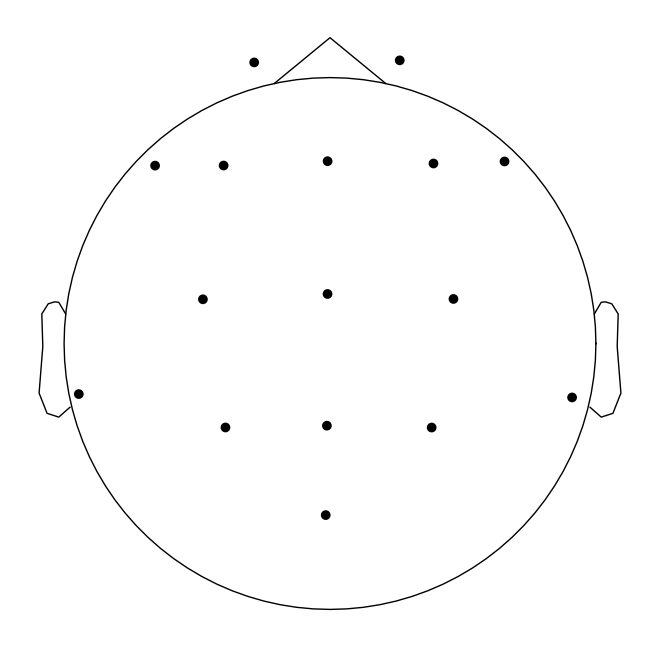

In [ ]:
raw.plot_sensors(show_names=True)
plt.show()

<!-- ![](images/raw_mne_data.png) -->
